In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysam
import re

def get_bin(L, pos):
    return pos//(L/20)

error_count = {bin_number: {'I':0,'D':0,'Sub':0,'M':0} for bin_number in range(20)}


bamfile = pysam.AlignmentFile("/qbio/shjo/23-1_bioinformatics/expansion/aligned/polyclonal.MD.bam", "rb")
for read in tqdm(bamfile.fetch(until_eof=True)):
    
    reference_seq = read.get_reference_sequence()
    pos_list = read.get_aligned_pairs()
    reference_start = read.reference_start
    
    S_num = 0   
    for op, length in read.cigartuples:
        if op == 4: S_num += length
        else: pass
      
    index = 0   
    for op, length in read.cigartuples: 
        if op == 0:   
            for i in range(index, length+index):
                read_pos, reference_pos = pos_list[i]
                if type(reference_pos) == type(None) or type(read_pos) == type(None): continue
                if reference_seq[reference_pos-reference_start] != read.query_sequence[read_pos]:
                    error_count[get_bin(len(reference_seq) + S_num, reference_pos-reference_start)]['Sub'] += 1
                else: 
                    error_count[get_bin(len(reference_seq) + S_num, reference_pos-reference_start)]['M'] += 1
            index += length   

        elif op == 1:  
            read_pos, reference_pos = pos_list[index-1]  
            if type(reference_pos) == type(None) or type(read_pos) == type(None): continue
            error_count[get_bin(len(reference_seq) + S_num, reference_pos-reference_start)]['I'] += length 
            index += length

        elif op == 2:    
            for i in range(index, length+index):
                _, reference_pos = pos_list[i]
                if type(reference_pos) == type(None): continue
                error_count[get_bin(len(reference_seq) + S_num, reference_pos-reference_start)]['D'] += 1
            index += length

        elif op == 4: 
            index += length    

        else: pass  
bamfile.close()

error_df = pd.DataFrame(error_count).T
error_df

10453516it [11:09, 15619.62it/s]


,I,D,Sub,M
0,0,0,42596,27518472
1,0,15,210769,21465702
2,101,2067,229276,22318841
3,262,13730,211653,21535670
4,4342,39171,237031,22521636
5,2096,73434,247310,20873548
6,1653,248205,277268,22189751
7,3479,172359,1160353,19116344
8,1499,275439,847537,21064947
9,1539,158250,572086,19484677


In [2]:
error_df['pI'] = (error_df['I']/error_df.sum(axis=1))*100 
error_df['pD'] = (error_df['D']/error_df.sum(axis=1))*100
error_df['pSub'] = (error_df['Sub']/error_df.sum(axis=1))*100
error_df['pM'] = (error_df['M']/error_df.sum(axis=1))*100
error_df

,I,D,Sub,M,pI,pD,pSub,pM
0,0,0,42596,27518472,0.000000,0.000000,0.154551,99.845448
1,0,15,210769,21465702,0.000000,0.000069,0.972339,99.027587
2,101,2067,229276,22318841,0.000448,0.009166,1.016732,98.973649
3,262,13730,211653,21535670,0.001204,0.063094,0.972611,98.963086
4,4342,39171,237031,22521636,0.019042,0.171786,1.039510,98.769656
5,2096,73434,247310,20873548,0.009888,0.346446,1.166755,98.476903
6,1653,248205,277268,22189751,0.007277,1.092602,1.220537,97.679574
7,3479,172359,1160353,19116344,0.017010,0.842727,5.673394,93.466839
8,1499,275439,847537,21064947,0.006755,1.241308,3.819554,94.932361
9,1539,158250,572086,19484677,0.007613,0.782774,2.829790,96.379806


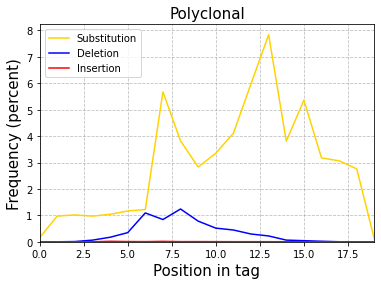

In [3]:
plt.plot(error_df['pSub'], label='Substitution', color='#FFD300')
plt.plot(error_df['pD'], label='Deletion', color='blue')
plt.plot(error_df['pI'], label='Insertion', color='red')

plt.title('Polyclonal', fontsize=15)
plt.grid(linestyle='--', color='grey', alpha=0.5)
plt.xlim(0,19)
plt.ylim(0,)

plt.xlabel('Position in tag', fontsize=15)
plt.ylabel('Frequency (percent)', fontsize=15)

plt.legend()
plt.show()

In [6]:
error_df.to_pickle('/qbio/shjo/23-1_bioinformatics/polyclonal.error_df.pkl')